# RSA and Human/CNN comparison

Olivia Yoo

Neuro 140

May 2, 2023

In [1]:
%matplotlib inline
import os
import random
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [2]:
ROIS = np.arange(4)
N_ROIS = 4
ROI_NAMES = ['lFFA', 'rFFA', 'lPPA', 'rPPA']
SUBJECTS = ['BE', 'KO', 'SN', 'TI']
N_SUBJECTS = 4
BINSIZE = [11, 12, 11, 12, 22, 24]
ORDERED_CATEGORIES = ['human face', 'human body part', 'nonhuman face', 'nonhuman body part', 'natural inanimate', 'artificial inanimate']

# Import data

In [3]:
# Human data
HUMAN_PATH = os.path.dirname(os.getcwd()) + '/data/colab_data/human_data.npy'
ALEXNET_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/alexnet_rdms.npy'
RN18_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/rn18_rdms.npy'
HUMAN_PERM_PATH = os.path.dirname(os.getcwd()) + '/data/colab_data/human_permuted.npz'
RN34_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/rn34_rdms.npy'
RN50_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/rn50_rdm.npy'
RN50_MOD_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/rn50_mod_rdm.npy'
RN101_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/rn101_rdm.npy'
RN101_MOD_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/rn101_mod_rdm.npy'
RN152_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/rn152_rdm.npy'
RN152_MOD_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/rn152_mod_rdm.npy'
MAP_PATH = os.path.dirname(os.getcwd()) + '/data/mapping/'

Human data:
- 2: 0 is RSM, 1 is RDM
- 4: # subjects - BE, KO, SN, TI
- 4: # ROIs - lFFA, rFFA, lPPA, rPPA
- 92: # images
- 92: # images

In [4]:
human_data = np.load(HUMAN_PATH)
human_rdms = human_data[1:][0]
human_rdms.shape

(4, 4, 92, 92)

Human permuted RDM data:
- Indices: ROI names
- Dimensions: 10000 bootstraps x 92 stimuli x 92 stimuli

In [5]:
human_perm_data = np.load(HUMAN_PERM_PATH)
human_perm_data = np.array([human_perm_data['lffa'], human_perm_data['rffa'],human_perm_data['lppa'], human_perm_data['rppa']])

In [6]:
B = human_perm_data.shape[1]

In [7]:
comb_human_perm_data = human_perm_data.reshape(40000, 92, 92)
comb_B = comb_human_perm_data.shape[0]

Layer data:
- 2: 0 is normal, 1 is modified images
- X: number of layers
- 92: # images
- 92: # images

In [8]:
alexnet_rdms = np.load(ALEXNET_PATH)
alexnet_rdms.shape

(2, 8, 92, 92)

In [9]:
rn18_rdms = np.load(RN18_PATH)
rn18_rdms.shape

(2, 21, 92, 92)

In [10]:
rn34_rdms = np.load(RN34_PATH)
rn34_rdms.shape

(2, 37, 92, 92)

In [11]:
rn50_rdm = np.load(RN50_PATH)
rn50_mod_rdm = np.load(RN50_MOD_PATH)
rn50_rdms = np.asarray([rn50_rdm, rn50_mod_rdm])
rn50_rdms.shape

(2, 54, 92, 92)

In [12]:
rn101_rdm = np.load(RN101_PATH)
rn101_mod_rdm = np.load(RN101_MOD_PATH)
rn101_rdms = np.asarray([rn101_rdm, rn101_mod_rdm])
rn101_rdms.shape

(2, 105, 92, 92)

In [13]:
rn152_rdm = np.load(RN152_PATH)
rn152_mod_rdm = np.load(RN152_MOD_PATH)
rn152_rdms = np.asarray([rn152_rdm, rn152_mod_rdm])
rn152_rdms.shape

(2, 156, 92, 92)

# Spearman Rank Correlation

Doing a kind of preliminary analysis for the Assignment 4 presentation:

Look at AlexNet layer activations. 

For each ROI, look at the average Spearman rank correlation between the AlexNet layer activation and all of the subjects.

Plot this as a bar graph for each of the layers. 

## AlexNet

In [14]:
alexnet_srcs = np.zeros((alexnet_rdms.shape[1], 4, 4)) # first dim (alexnet layer), second dim (ROI), third dim (subject)

# iterate through alexnet layers
for i in range(alexnet_rdms.shape[1]):
    layer_rdm = alexnet_rdms[1, i]

    # iterate through rois
    for roi in ROIS:

        # iterate through subjects
        for subj, _ in enumerate(SUBJECTS):

            # get subject RDM
            subj_rdm = human_rdms[roi, subj]
            
            # calculate spearman correlation
            res = spearmanr(layer_rdm, subj_rdm, axis=None)

            alexnet_srcs[i, roi, subj] = res.statistic

In [15]:
# get averages for each layer
alexnet_layer_avgs = np.mean(alexnet_srcs, axis=2)

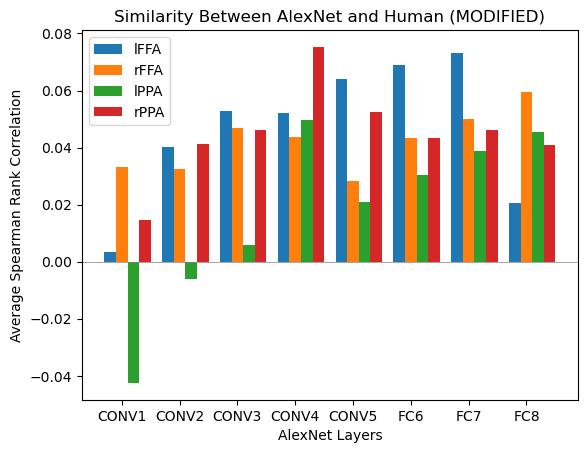

In [16]:
# plot the different layers/regions
x = np.arange(alexnet_layer_avgs.shape[0])
alexnet_layer_names = ['CONV1', 'CONV2', 'CONV3', 'CONV4', 'CONV5', 'FC6', 'FC7', 'FC8']

plt.bar(x - 0.2, alexnet_layer_avgs[:, 0], 0.2, label = 'lFFA')
plt.bar(x, alexnet_layer_avgs[:, 1], 0.2, label = 'rFFA')
plt.bar(x + 0.2, alexnet_layer_avgs[:, 2], 0.2, label = 'lPPA')
plt.bar(x + 0.4, alexnet_layer_avgs[:, 3], 0.2, label = 'rPPA')


plt.axhline(y=0, color='gray', linewidth=0.5, linestyle='-')
plt.xticks(x, alexnet_layer_names)
plt.xlabel("AlexNet Layers")
plt.ylabel("Average Spearman Rank Correlation")
plt.title("Similarity Between AlexNet and Human (MODIFIED)")
plt.legend()
plt.show()

## ResNet18

In [17]:
rn18_srcs = np.zeros((rn18_rdms.shape[1], 4, 4)) # first dim (resnet layer), second dim (ROI), third dim (subject)

# iterate through alexnet layers
for i in range(rn18_rdms.shape[1]):
    layer_rdm = rn18_rdms[1, i]

    # iterate through rois
    for roi in ROIS:

        # iterate through subjects
        for subj, _ in enumerate(SUBJECTS):

            # get subject RDM
            subj_rdm = human_rdms[roi, subj]
            
            # calculate spearman correlation
            res = spearmanr(layer_rdm, subj_rdm, axis=None)

            rn18_srcs[i, roi, subj] = res.statistic

# get averages for each layer
rn18_layer_avgs = np.mean(rn18_srcs, axis=2)

In [18]:
rn18_layer_names = ['C1',
                    'C2',
                    'C3',
                    'C4',
                    'C5',
                    'C6',
                    'C7',
                    'C8',
                    'C9',
                    'C10',
                    'C11',
                    'C12',
                    'C13',
                    'C14',
                    'C15',
                    'C16',
                    'C17',
                    'C18',
                    'C19',
                    'C20',
                    'FC21',]

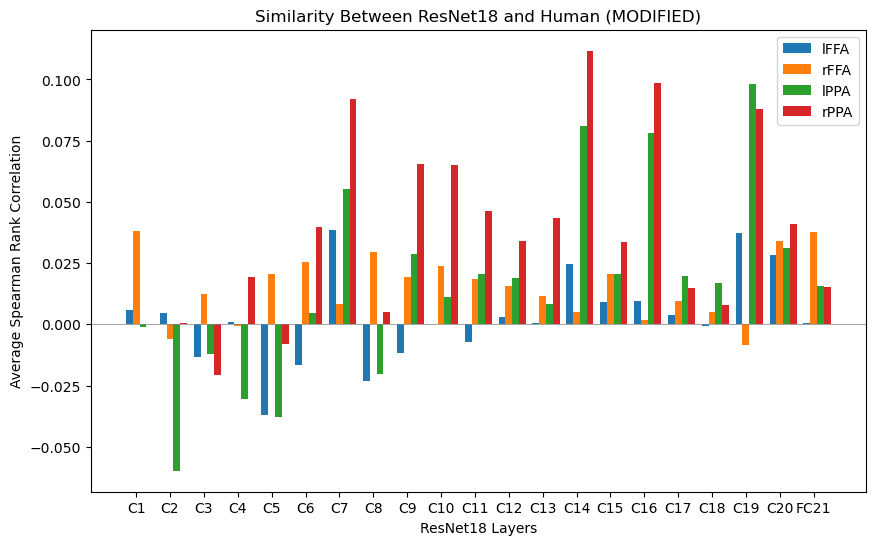

In [19]:
# plot the different layers/regions
plt.figure(figsize=(10,6))
x = np.arange(rn18_layer_avgs.shape[0])

plt.bar(x - 0.2, rn18_layer_avgs[:, 0], 0.2, label = 'lFFA')
plt.bar(x, rn18_layer_avgs[:, 1], 0.2, label = 'rFFA')
plt.bar(x + 0.2, rn18_layer_avgs[:, 2], 0.2, label = 'lPPA')
plt.bar(x + 0.4, rn18_layer_avgs[:, 3], 0.2, label = 'rPPA')


plt.axhline(y=0, color='gray', linewidth=0.5, linestyle='-')
plt.xticks(x, rn18_layer_names)
plt.xlabel("ResNet18 Layers")
plt.ylabel("Average Spearman Rank Correlation")
plt.title("Similarity Between ResNet18 and Human (MODIFIED)")
plt.legend()
plt.show()

# Mapping Matrix (Human/CNN)

## Function to generate

In [20]:
SIG_THRESH = 0.001

In [21]:
def build_map(corr_sum, n_sig):
    if n_sig == 0:
        return 0
    else:
        return corr_sum / n_sig

In [22]:
def build_network_map(network_rdms, image_mod):
   relevant_rdms = network_rdms[image_mod]
   n_network_layers = relevant_rdms.shape[0]

   # set up relevant results
   network_map = np.zeros([N_ROIS, n_network_layers])
   network_corrs = np.zeros([N_ROIS, n_network_layers])
   network_signs = np.zeros([N_ROIS, n_network_layers])
   
   # for each layer
   for i in range(n_network_layers):
      
      network_rdm = relevant_rdms[i]

      # Create null distribution of correlations between layer and permuted human RDMs
      permuted_corrs = []

      for j in range(comb_B):
         res = spearmanr(network_rdm, comb_human_perm_data[i], axis=None)
         permuted_corrs.append(res.statistic)

      lower_sig_bound = np.quantile(permuted_corrs, SIG_THRESH)
      upper_sig_bound = np.quantile(permuted_corrs, 1-SIG_THRESH)

      # find correlations and their significance
      # look at a specific ROI
      for k in range(N_ROIS):
         
         # look at each human
         for l in range(N_SUBJECTS):

            tmp1 = network_corrs[k, i]
            tmp2 = network_signs[k, i]

            # calculate correlation
            res = spearmanr(network_rdm, human_rdms[l,k], axis=None)
            res_corr = res.statistic

            # add correlation to sum
            network_corrs[k, i] = tmp1 + res_corr

            # check if correlation is sigificant
            if (res_corr < lower_sig_bound) | (res_corr > upper_sig_bound):
                  network_signs[k, i] = tmp2 + 1   

      # build mapping matrix  
      for m in range(N_ROIS):
         for n in range(n_network_layers):
            network_map[m,n] = build_map(network_corrs[m,n], network_signs[m,n]) 

   return network_map

### AlexNet

In [21]:
alexnet_map = build_network_map(alexnet_rdms, 0) # takes ~3.5 min

In [22]:
np.save(MAP_PATH + 'alexnet_map.npy', alexnet_map)

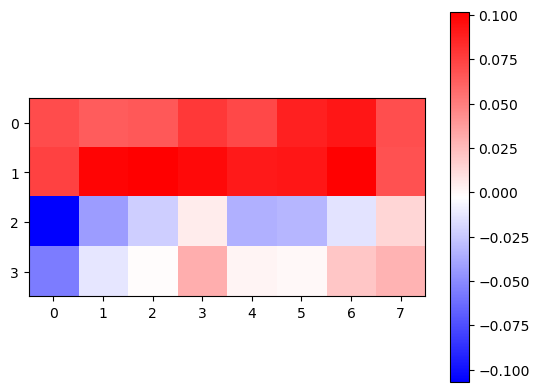

In [23]:
plt.imshow(alexnet_map, cmap='bwr')
plt.colorbar();

In [29]:
alexnet_mod_map = build_network_map(alexnet_rdms, 1) # takes ~3.5 min

In [119]:
np.save(MAP_PATH + 'alexnet_mod_map.npy', alexnet_mod_map)

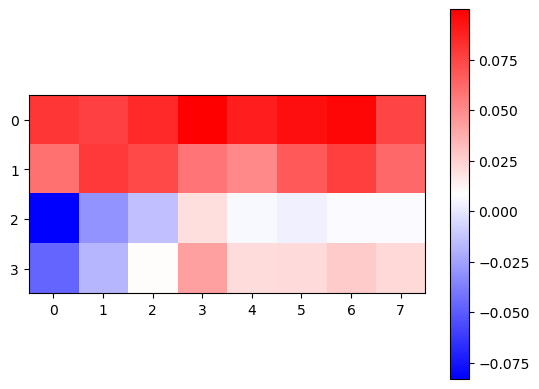

In [31]:
plt.imshow(alexnet_mod_map, cmap='bwr')
plt.colorbar();

### ResNet18

In [120]:
rn18_map = build_network_map(rn18_rdms, 0) # took 9.5 min
np.save(MAP_PATH + 'rn18_map.npy', rn18_map) 

KeyboardInterrupt: 

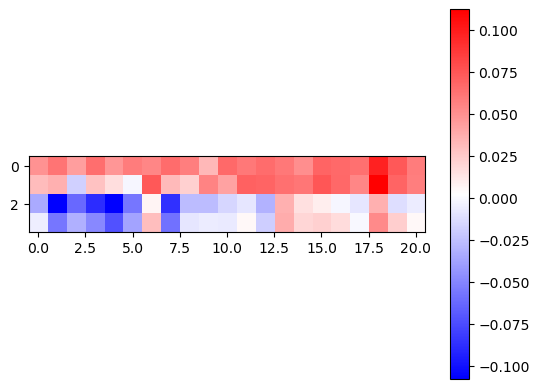

In [167]:
plt.imshow(rn18_map, cmap='bwr')
plt.colorbar();

In [110]:
rn18_mod_map = build_network_map(rn18_rdms, 1)
np.save(MAP_PATH + 'rn18_mod_map.npy', rn18_mod_map)

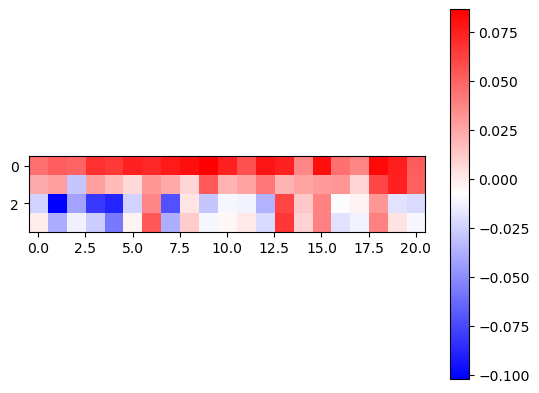

In [121]:
plt.imshow(rn18_mod_map, cmap='bwr')
plt.colorbar();

### ResNet34

In [ ]:
rn34_map = build_network_map(rn34_rdms, 0)
np.save(MAP_PATH + 'rn34_map.npy', rn34_map) 

In [ ]:
rn34_mod_map = build_network_map(rn34_rdms, 1)
np.save(MAP_PATH + 'rn34_mod_map.npy', rn34_mod_map) 

### ResNet50

In [ ]:
rn50_map = build_network_map(rn50_rdms, 0)
np.save(MAP_PATH + 'rn50_map.npy', rn50_map) 

In [ ]:
rn50_mod_map = build_network_map(rn50_rdms, 1)
np.save(MAP_PATH + 'rn50_mod_map.npy', rn50_mod_map) 

### ResNet101

In [ ]:
rn101_map = build_network_map(rn101_rdms, 0)
np.save(MAP_PATH + 'rn101_map.npy', rn101_map) 

In [ ]:
rn101_mod_map = build_network_map(rn101_rdms, 1)
np.save(MAP_PATH + 'rn101_mod_map.npy', rn101_mod_map) 

### ResNet152

In [ ]:
rn152_map = build_network_map(rn152_rdms, 0)
np.save(MAP_PATH + 'rn152_map.npy', rn152_map) 

In [ ]:
rn152_mod_map = build_network_map(rn152_rdms, 1)
np.save(MAP_PATH + 'rn152_mod_map.npy', rn152_mod_map) 

# Mapping Matrix (CNN only)

## Function to generate

In [50]:
def build_layer_map(network_rdms, image_mod):
    # get number of layers
    n_layers = network_rdms.shape[1]

    # create matrix to store layer correlations
    layer_matrix = np.zeros([n_layers, n_layers])

    # calculate layer correlations and add to matrix
    for i in range(n_layers):
        for j in range(n_layers):
            if i <= j:
                corr = spearmanr(network_rdms[image_mod, i], network_rdms[image_mod, j], axis=None).statistic
                layer_matrix[i, j] = layer_matrix[j, i] = corr
    
    return layer_matrix

### AlexNet

In [69]:
alexnet_layer_corrs = build_layer_map(alexnet_rdms, 0)
alexnet_mod_layer_corrs = build_layer_map(alexnet_rdms, 1)
np.savez_compressed(MAP_PATH + 'alexnet_layer_corrs', np.asarray([alexnet_layer_corrs, alexnet_mod_layer_corrs]))

### ResNet18

In [70]:
rn18_layer_corrs = build_layer_map(rn18_rdms, 0)
rn18_mod_layer_corrs = build_layer_map(rn18_rdms, 1)
np.savez_compressed(MAP_PATH + 'rn18_layer_corrs', np.asarray([rn18_layer_corrs, rn18_mod_layer_corrs]))

### ResNet34

In [71]:
rn34_layer_corrs = build_layer_map(rn34_rdms, 0)
rn34_mod_layer_corrs = build_layer_map(rn34_rdms, 1)
np.savez_compressed(MAP_PATH + 'rn34_layer_corrs', np.asarray([rn34_layer_corrs, rn34_mod_layer_corrs]))

### ResNet50

In [72]:
rn50_layer_corrs = build_layer_map(rn50_rdms, 0)
rn50_mod_layer_corrs = build_layer_map(rn50_rdms, 1)
np.savez_compressed(MAP_PATH + 'rn50_layer_corrs', np.asarray([rn50_layer_corrs, rn50_mod_layer_corrs]))

### ResNet101

In [73]:
rn101_layer_corrs = build_layer_map(rn101_rdms, 0)
rn101_mod_layer_corrs = build_layer_map(rn101_rdms, 1)
np.savez_compressed(MAP_PATH + 'rn101_layer_corrs', np.asarray([rn101_layer_corrs, rn101_mod_layer_corrs]))

### ResNet152

In [74]:
rn152_layer_corrs = build_layer_map(rn152_rdms, 0)
rn152_mod_layer_corrs = build_layer_map(rn152_rdms, 1)
np.savez_compressed(MAP_PATH + 'rn152_layer_corrs.npy', np.asarray([rn152_layer_corrs, rn152_mod_layer_corrs]))